In [1]:
# For passwords & database access:
import psycopg2
import psycopg2.extras
import getpass

# For plotting
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display
import ipywidgets

# For math
import numpy as np
import pandas as pd

This notebook searches the COSMOS field for candidates that (on their first night of detection) rose by at least 0.2 mag over at least 4 detections

In [2]:
# Logging in
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect( f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'" )

db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  kennedyt
DB Password:  ············


In [3]:
Term = "2021B"
# Term = "2021B"
if Term == "2021A": sgn = "<"
elif Term == "2021B": sgn = ">"
else:
    print("set 'Term' equal to either '2021A' or '2021B'")

#### The filter

In [4]:
# Get a list of every MJD for which we have an image

query = ('SELECT e.mjd FROM exposures e '
         'WHERE e.mjd '+sgn+' 59377 ' 
         'LIMIT 10000000')
cursor.execute( query )

datesquery = cursor.fetchall()

In [5]:
# Make a list of every observing night (by rounding to the nearest MJD)
odates = np.unique( np.round( datesquery ) )
odates

array([59474., 59475., 59477., 59478., 59480., 59481., 59482., 59483.,
       59486., 59489., 59492., 59498., 59501., 59504., 59505., 59507.,
       59510., 59511., 59512., 59519., 59522., 59525., 59528., 59532.,
       59533., 59534., 59535., 59537., 59540.])

In [7]:
fr = []
frdates = []
for field in ["COSMOS", "ELIAS"]:
# for field in ["ELIAS"]:
    for fil in ["g","r","i"]:
        tempfr = [] # List for the names of fast-rising candidates
        tempfrdates = [] # List for the dates on which fast riser behavior was observed

        oldcands = np.array( [] ) # used to check if candidates have been detected before

        for i in range(len(odates)):
            # Loop through each observing night
            # Grab all detections within a day of the night in question
            lodate = odates[i] - 1
            hidate = odates[i] + 1
            if field == "COSMOS":
                query = ('SELECT o.candidate_id, o.id, e.mjd, o.mag, rbs.rb, e.id FROM objects o '
                         'JOIN subtractions s ON s.id=o.subtraction_id '
                         'JOIN exposures e on s.exposure_id = e.id '
                         'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
                         'WHERE q3c_radial_query(e.ra,e.dec,150,2.2,3) '
                         'AND rbs.rb > 0.4 '
                         'AND e.mjd > %s '
                         'AND e.mjd < %s '
                         'AND e.filter = %s'
                         'AND e.mjd '+sgn+' 59377 ' 
                         'LIMIT 10000000')
            elif field == "ELIAS":
                query = ('SELECT o.candidate_id, o.id, e.mjd, o.mag, rbs.rb, e.id FROM objects o '
                         'JOIN subtractions s ON s.id=o.subtraction_id '
                         'JOIN exposures e on s.exposure_id = e.id '
                         'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
                         'WHERE q3c_radial_query(o.ra,o.dec,8.5,-43.5,2) '
                         'AND rbs.rb > 0.4 '
                         'AND e.mjd > %s '
                         'AND e.mjd < %s '
                         'AND e.filter = %s'
                         'AND e.mjd '+sgn+' 59377 ' 
                         'LIMIT 10000000')
            cursor.execute( query, ( lodate, hidate, fil ) )

            # Store that nights detections in an array
            tempres = np.array( cursor.fetchall(), dtype=str ).transpose()

            if len( tempres ) > 0: # Eliminates errors from gaps in the ELIAS observations by skipping empty nights
                # Cut out duplicate objects
                dupearr = np.array( [tempres[0], tempres[2], tempres[3], tempres[4], tempres[5]] ).transpose()
                dupearr = [ " ".join(j) for j in dupearr ]
                dupearr, ind = np.unique( dupearr, return_index=True )

                # Rejoin the array without the duplicates
                uarr = np.array( [ i.split(" ") for i in dupearr ] ).transpose()
                res = np.array( [uarr[0], tempres[1][ind], uarr[1], uarr[2], uarr[3], uarr[4]] )

                # Create an array of each unique candidate detected that night
                ucands, uind, ucounts = np.unique( res[0], return_counts=True, return_index=True )

                # Isolate those with at least 4 detections
                goodcands = ucands[ ucounts > 3 ]


                # Make an array of detections for each of those candidates, store all of those arrays in "arr"
                arr = np.ones( len( goodcands ), dtype=object )
                for j in range( len( goodcands ) ):
                    arr[j] = res[:,res[0,:] == goodcands[j]]
                # Mask out those that 
                # A) have been detected in previous nights, 
                # B) don't rise in every subsequent detection, or 
                # C) don't change by at least 0.2 mag
                good = np.ones( len( arr ), dtype=bool )
                for j in range( len( arr ) ):
                    # A)
                    if arr[j][0][0] in oldcands:
                        good[j] = False
                    for k in range( len( arr[j][3] ) - 1 ):
                        # B)
                        if arr[j][3][k] < arr[j][3][k + 1]:
                            good[j] = False
                        # C)
                        if np.max( arr[j][3].astype(float) ) - np.min( arr[j][3].astype(float) ) < 0.2:
                            good[j] = False

                # Apply those cuts and append the candidates that passed to fr and frdates
                for j in range( len( arr[good] ) ):
                    tempfr.append( arr[good][j][0][0] )
                    tempfrdates.append( [lodate, hidate] )
            
            # Make a note of all candidates detected this night (for cutting out things that have been previously detected)
            try:
                oldcands = np.append( oldcands, ucands )
            except NameError:
                pass
            fr.append(tempfr)
            frdates.append(tempfrdates)
            

x = []
ind = np.unique(fr, return_index=True)[1]
for i in [fr[ind] for ind in sorted(ind)]:
    x.extend(i)
fr = x

y = []
ind = np.unique(frdates, return_index=True)[1]
for i in [frdates[ind] for ind in sorted(ind)]:
    y.extend(i)
frdates = y
del x, y, ind

/tmp/ipykernel_54335/308145246.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arr[j][0][0] in oldcands:
/usr/common/software/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


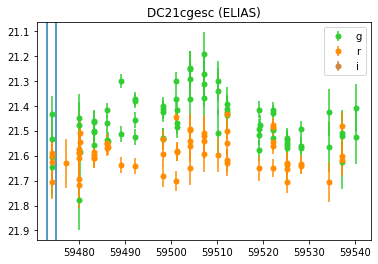

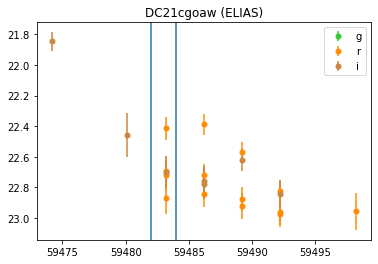

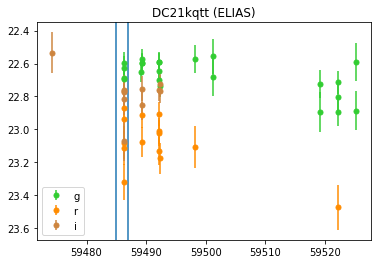

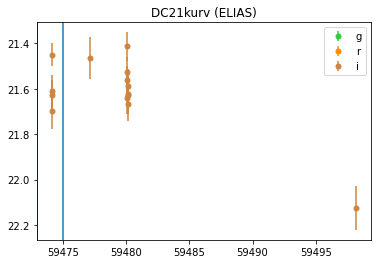

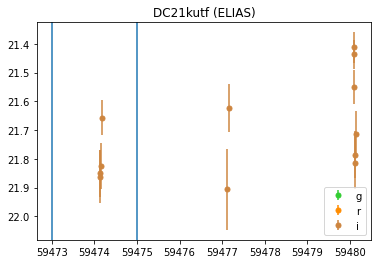

In [8]:
### Plotting up each of the identified fast risers
for i in range( len( fr ) ):
    query = ('SELECT c.id, e.mjd, o.mag, o.magerr, e.filter, o.ra FROM objects o '
             'JOIN candidates c ON c.id=o.candidate_id '
             'JOIN subtractions s ON s.id=o.subtraction_id '
             'JOIN exposures e ON e.id=s.exposure_id '
             'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
             'WHERE c.id=%s '
             'AND e.mjd '+sgn+' 59377 ' 
             'AND rbs.rb > 0.4')
    cursor.execute( query, ( fr[i], ) )
    
    array = np.array( cursor.fetchall() ).transpose()
    gmsk = array[4] == 'g'
    rmsk = array[4] == 'r'
    imsk = array[4] == 'i'
    
    
    # Color consistency
    if float(array[5][0]) < 50:
        field = "ELIAS"
    else:
        field = "COSMOS"
    if field == "COSMOS": c = ["darkgreen","red","brown"]
    elif field == "ELIAS": c = ["limegreen","darkorange","peru"]
    
    
    plt.errorbar( ( array[1][gmsk] ).astype(float), 
                 ( array[2][gmsk] ).astype(float), 
                 yerr=array[3][gmsk].astype(float), 
                 fmt='o', 
                 markersize=5, 
                 ls= '', 
                 color=c[0], 
                 label='g' )
    plt.errorbar( ( array[1][rmsk] ).astype(float), 
                 ( array[2][rmsk] ).astype(float), 
                 yerr=array[3][rmsk].astype(float), 
                 fmt='o', 
                 markersize=5, 
                 ls= '', 
                 color=c[1], 
                 label='r' )
    plt.errorbar( ( array[1][imsk] ).astype(float), 
                 ( array[2][imsk] ).astype(float), 
                 yerr=array[3][imsk].astype(float), 
                 fmt='o', 
                 markersize=5, 
                 ls= '', 
                 color=c[2], 
                 label='i' )
    
    # Indicate the interesting part of the light curve
    plt.axvline( float( frdates[i][0] ) )
    plt.axvline( float( frdates[i][1] ) )
    
    plt.title( array[0][0]+" ("+field+")")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

In [9]:
### This cell pulls out the reference, science, and subtraction images for eack of the SNe the filter detected, for every good detection

for i in fr:
    query = ( 'SELECT cand.id, e.mjd,e.filename,e.filter,c.sci_jpeg,c.ref_jpeg,c.diff_jpeg FROM cutouts c '
              'INNER JOIN objects o ON c.object_id=o.id '
              'INNER JOIN candidates cand ON o.candidate_id=cand.id '
              'INNER JOIN subtractions s ON o.subtraction_id=s.id '
              'INNER JOIN exposures e ON s.exposure_id=e.id '
              'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
              'WHERE cand.id=%s '
              'AND e.mjd '+sgn+' 59377 ' 
              'AND rbs.rb > 0.4 '
              'ORDER BY e.mjd '
              'LIMIT 3')
    cursor.execute( query, ( i, ) )
    for row in cursor:
        label = ipywidgets.HTML( f'<b>Candidate</b>{row["id"]}<br><b>{row["filename"]}</b><br><b>Filter:</b> {row["filter"]}' )
        newimg = ipywidgets.Image( value=bytes(row["sci_jpeg"]), width=102, height=102, format='jpeg' )
        refimg = ipywidgets.Image( value=bytes(row["ref_jpeg"]), width=102, height=102, format='jpeg' )
        subimg = ipywidgets.Image( value=bytes(row["diff_jpeg"]), width=102, height=102, format='jpeg' )
        box = ipywidgets.HBox( [ newimg, refimg, subimg, label ] )
        display( box )
    print("")
    print("")    
    print("")    
    print("")

In [10]:
engine="SDSS"

coordarr = np.empty( len( fr ), dtype=object )
for i in range(len(fr)):
    query = ('SELECT c.id, c.ra, c.dec FROM candidates c '
            'WHERE c.id=%s ')
    cursor.execute( query, (fr[i], ) )
    coordarr[i] = cursor.fetchall()[0]


if engine == "SDSS":
    for i in coordarr:
        print(i[0])
        print(str(i[1]))
        print(str(i[2]))
elif engine=="TNS":
    for i in coordarr:
        if i[2]>0:
            print(i[0])
            print(str(i[1]),"+"+str(i[2]))
        else:
            print(i[0])
            print(str(i[1]),str(i[2]))

DC21cgesc
7.75785356869088
-42.7816063284422
DC21cgoaw
7.78571203956245
-43.2592318027686
DC21kqtt
10.3721736153821
-43.5543003944234
DC21kurv
7.35341095023599
-43.8986687544181
DC21kutf
9.45712169889595
-43.4376772897517


In [ ]:
# From SDSS matches (2021A):
# DC21fah-- STAR
# DC21mis-- STAR
# DC21nmo-- GALAXY
# DC21tbc-- GALAXY
# DC21crq-- STAR
# DC21flsx-- GALAXY
# ELIAS fast risers outside the SDSS footprint